<a href="https://colab.research.google.com/github/rimhm/fullcalendar-docs/blob/main/lungCancerDetectionByType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reset -f

In [8]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.16.1


In [2]:
!pip install tensorflow==2.16.1


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

import warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

def count_images_per_class(path):
    num_of_images = {}
    for folder in os.listdir(path):
        class_path = os.path.join(path, folder)
        if os.path.isdir(class_path):
            num_of_images[folder] = sum([len(files) for _, _, files in os.walk(class_path)])
    return num_of_images

# Assuming you have a path containing subdirectories for each class
dataset_path = "/content/drive/MyDrive/PIDS/data2T"
class_counts = count_images_per_class(dataset_path)
print(class_counts)


{'test': 315, 'train': 613, 'valid': 72}


# 🔍DATA EXPLORATION AND VISUALIZATION


In [5]:
# File Directory for both the train and test
train_path = "/content/drive/MyDrive/PIDS/data2T/train"
val_path = "/content/drive/MyDrive/PIDS/data2T/valid"
test_path = "/content/drive/MyDrive/PIDS/data2T/test"

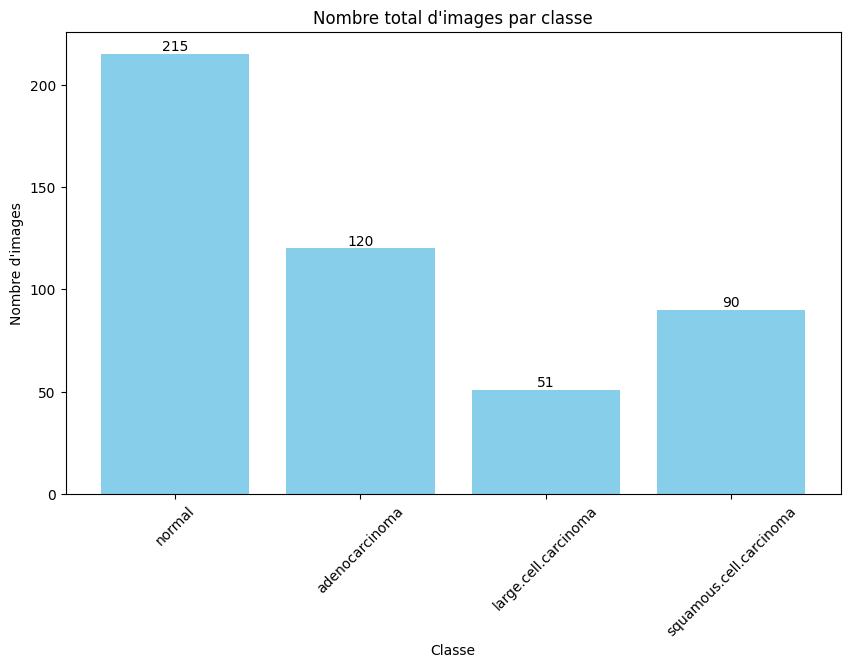

In [6]:
import os
import matplotlib.pyplot as plt

# Chemin vers le dossier racine contenant les sous-dossiers de train, valid et test
root_folder = "/content/drive/MyDrive/PIDS/data2T"

# Définir la fonction pour compter le nombre total d'images par classe
def get_total_images_per_class(root_folder):
    num_of_images = {}
    for dataset_type in ["train", "valid", "test"]:
        dataset_folder = os.path.join(root_folder, dataset_type)
        for cancer_type in ["adenocarcinoma", "large.cell.carcinoma", "normal", "squamous.cell.carcinoma"]:
            class_folder = os.path.join(dataset_folder, cancer_type)
            if os.path.isdir(class_folder):
                num_of_images[cancer_type] = num_of_images.get(cancer_type, 0) + len(os.listdir(class_folder))
    return num_of_images

# Obtenir le nombre total d'images par classe
total_images_per_class = get_total_images_per_class(root_folder)

# Extraire les noms de classe et les nombres d'images
classes = list(total_images_per_class.keys())
image_counts = list(total_images_per_class.values())

# Créer un diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, image_counts, color='skyblue')

# Ajouter les nombres d'images à chaque barre
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.title('Nombre total d\'images par classe')
plt.xticks(rotation=45)  # Rotation des étiquettes de classe pour une meilleure lisibilité
plt.show()


In [7]:
import os

def get_image_formats(directory):
    image_formats = set()
    # Traverse through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Get the file extension
            file_ext = os.path.splitext(filename)[1].lower()
            if file_ext.startswith('.'):
                file_ext = file_ext[1:]
            # Add the file extension to the set
            image_formats.add(file_ext)
    return image_formats

# Example usage:
data_directory = "/content/drive/MyDrive/PIDS/data2T"

formats = get_image_formats(data_directory)
print("Image formats in the dataset:", formats)


Image formats in the dataset: {'png', 'jpg'}


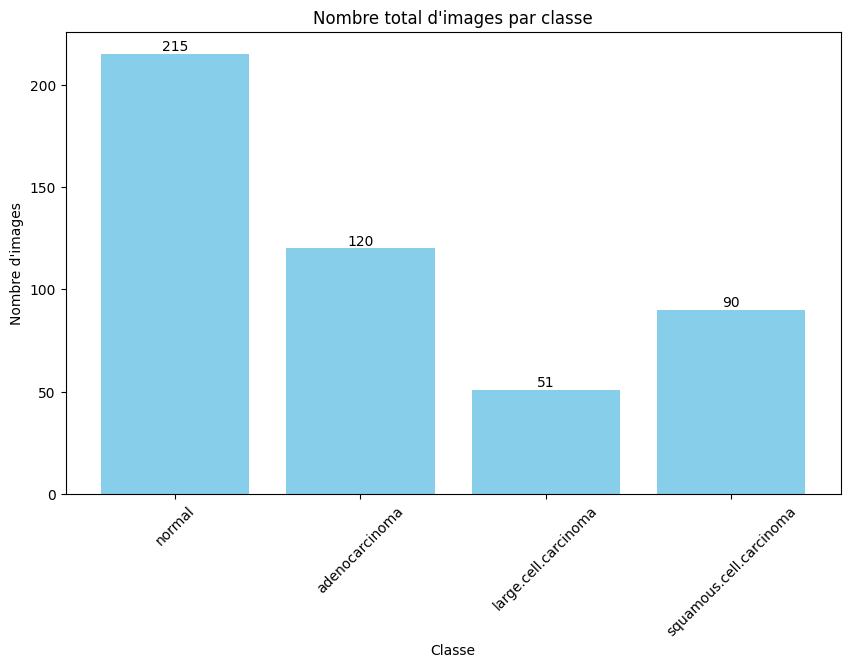

In [8]:
import os
import matplotlib.pyplot as plt

# Chemin vers le dossier racine contenant les sous-dossiers de train, valid et test
root_folder = "/content/drive/MyDrive/PIDS/data2T"

# Définir la fonction pour compter le nombre total d'images par classe
def get_total_images_per_class(root_folder):
    num_of_images = {}
    for dataset_type in ["train", "valid", "test"]:
        dataset_folder = os.path.join(root_folder, dataset_type)
        for cancer_type in ["adenocarcinoma", "large.cell.carcinoma", "normal", "squamous.cell.carcinoma"]:
            class_folder = os.path.join(dataset_folder, cancer_type)
            if os.path.isdir(class_folder):
                num_of_images[cancer_type] = num_of_images.get(cancer_type, 0) + len(os.listdir(class_folder))
    return num_of_images

# Obtenir le nombre total d'images par classe
total_images_per_class = get_total_images_per_class(root_folder)

# Extraire les noms de classe et les nombres d'images
classes = list(total_images_per_class.keys())
image_counts = list(total_images_per_class.values())

# Créer un diagramme à barres
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, image_counts, color='skyblue')

# Ajouter les nombres d'images à chaque barre
for bar, count in zip(bars, image_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.title('Nombre total d\'images par classe')
plt.xticks(rotation=45)  # Rotation des étiquettes de classe pour une meilleure lisibilité
plt.show()


In [9]:
# Define function to count number of images per class using a dictionary
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'normal': 148} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'normal': 13} 

 {'squamous.cell.carcinoma': 90, 'normal': 54, 'adenocarcinoma': 120, 'large.cell.carcinoma': 51}


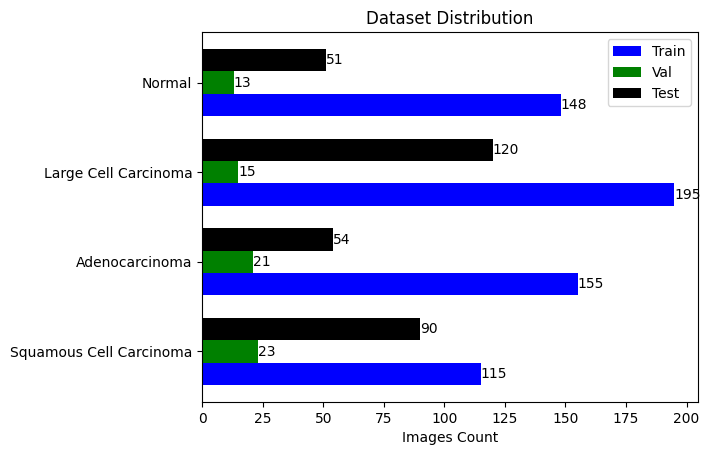

In [10]:

import matplotlib.pyplot as plt
import numpy as np

# Labels for each class
labels = ['Squamous Cell Carcinoma','Adenocarcinoma',  'Large Cell Carcinoma', 'Normal',]

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Total count for each class
total_counts_train = train_list
total_counts_val = val_list
total_counts_test = test_list

# Set color for each dataset
color_train = 'blue'
color_val = 'green'
color_test = 'black'  # Changed color to black

# Create plot
fig, ax = plt.subplots()

# Width of bars
bar_width = 0.25

# Create horizontal bar chart for train
y_pos_train = np.arange(len(labels))
ax.barh(y_pos_train - bar_width, total_counts_train, align='center', color=color_train, height=bar_width, label='Train')

# Create horizontal bar chart for val
ax.barh(y_pos_train, total_counts_val, align='center', color=color_val, height=bar_width, label='Val')

# Create horizontal bar chart for test
ax.barh(y_pos_train + bar_width, total_counts_test, align='center', color=color_test, height=bar_width, label='Test')

# Set y-axis labels
ax.set_yticks(y_pos_train)
ax.set_yticklabels(labels)

# Add counts on the bars for train
for i, count in enumerate(total_counts_train):
    ax.text(count, i - bar_width, str(count), ha='left', va='center')

# Add counts on the bars for val
for i, count in enumerate(total_counts_val):
    ax.text(count, i, str(count), ha='left', va='center')

# Add counts on the bars for test
for i, count in enumerate(total_counts_test):
    ax.text(count, i + bar_width, str(count), ha='left', va='center')

# Add labels and title
ax.set_xlabel('Images Count')
ax.set_title('Dataset Distribution')

# Add legend
ax.legend()

# Show plot
plt.show()

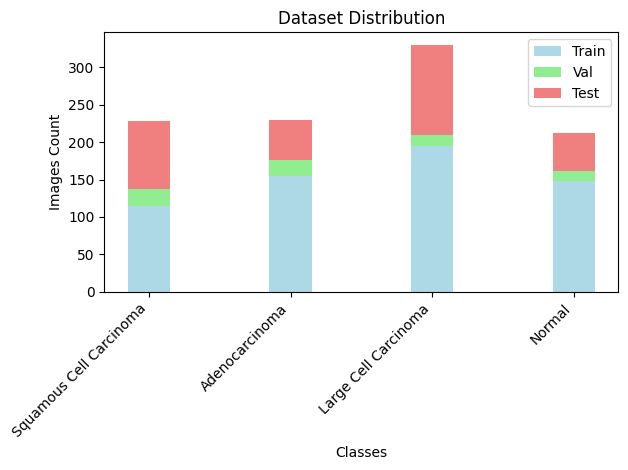

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for each class
labels = ['Squamous Cell Carcinoma', 'Adenocarcinoma', 'Large Cell Carcinoma', 'Normal']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Total count for each class
total_counts_train = train_list
total_counts_val = val_list
total_counts_test = test_list

# Set color for each class
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue']

# Create plot
fig, ax = plt.subplots()

# Width of bars
bar_width = 0.3

# Positions for bars
positions = np.arange(len(labels))

# Create stacked bar chart for train
ax.bar(positions, total_counts_train, color=colors[0], label='Train', width=bar_width)

# Create stacked bar chart for val
ax.bar(positions, total_counts_val, color=colors[1], label='Val', width=bar_width, bottom=total_counts_train)

# Create stacked bar chart for test
ax.bar(positions, total_counts_test, color=colors[2], label='Test', width=bar_width, bottom=np.array(total_counts_train) + np.array(total_counts_val))

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Images Count')
ax.set_title('Dataset Distribution')
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=45, ha='right')

# Add legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


# ⚙️DATA PREPARATION


## Removing Corrupted or Damaged Images

In [12]:
# Define function to count number of images per class using a dictionary
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'normal': 148} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15, 'normal': 13} 

 {'squamous.cell.carcinoma': 90, 'normal': 54, 'adenocarcinoma': 120, 'large.cell.carcinoma': 51}


In [13]:
# Print the percentage of data in each set
total_samples = sum(train_set.values()) + sum(val_set.values()) + sum(test_set.values())
percentage_train = (sum(train_set.values()) / total_samples) * 100
percentage_val = (sum(val_set.values()) / total_samples) * 100
percentage_test = (sum(test_set.values()) / total_samples) * 100

print(f"Percentage of data in training set: {percentage_train:.2f}%")
print(f"Percentage of data in validation set: {percentage_val:.2f}%")
print(f"Percentage of data in testing set: {percentage_test:.2f}%")

Percentage of data in training set: 61.30%
Percentage of data in validation set: 7.20%
Percentage of data in testing set: 31.50%


# RENAME IMAGES

# ⚙️DATA PREPROCESSING


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Définir la fonction de redimensionnement
def resize_image(image):
    target_size = (256, 256)  # Spécifier la taille cible pour le redimensionnement
    # Redimensionner l'image à la taille cible
    resized_image = cv2.resize(image, target_size)
    return resized_image




# Image data generator with specified augmentation configurations (mostly geometric transformations)
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,# pour aider a detecter les variation ou déformation des objets dans l'image
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4,
                                  preprocessing_function=resize_image)

# Using data generator to create augmented data from image files in train_path directory
train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
train_data.class_indices

Found 613 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [15]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [16]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (256,256),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

# 👀SAMPLE VISUALIZATION


Ensuring that data preprocessing has been correctly applied and checking whether the labels are correctly assigned.

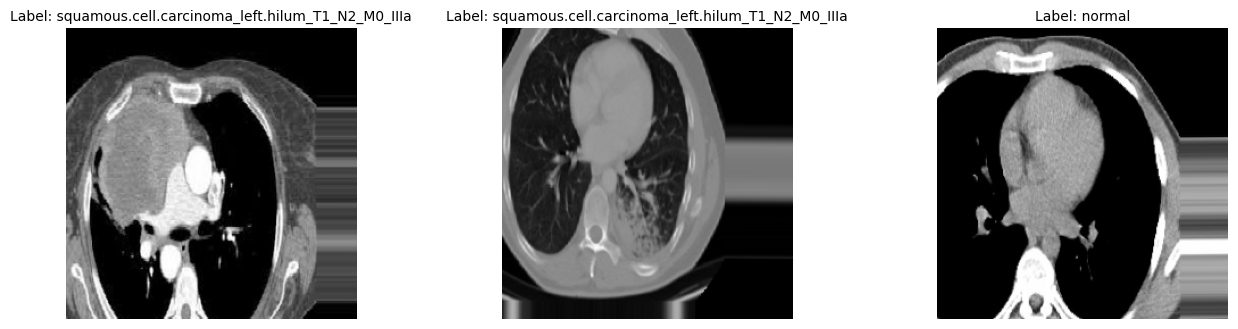

In [17]:
import cv2  # Importer le module OpenCV

# Function to plot sample images with labels
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

# **MODLING**

# EfficientNetB0

In [19]:
from tensorflow.keras.applications import EfficientNetB0


In [20]:
# importer et instancier le modèle EfficientNetB0 pré-entraîné sur l'ensemble de données ImageNet.
base_model = EfficientNetB0(input_shape = (256, 256, 3),
                            include_top = False,#Excludes the top classification layers
                            # Only the convolutional and pooling layers of the model will be loaded
                            weights = 'imagenet')# # Pre-trained weights on the ImageNet dataset will be used

In [21]:
mc = ModelCheckpoint(
    filepath="./ct_effnet_best_model.keras",  # Changement de l'extension du fichier
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
)
# Storing the ModelCheckpoint callback in a list.
call_back = [ mc];
#un outil de visualisation fourni avec TensorFlow pour suivre les métriques d'entraînement et de validation.
tensorboard = TensorBoard(log_dir = 'logs')
# ReduceLROnPlateau callback: reduces the learning rate when a metric has stopped improving.
# It monitors the 'val_accuracy' metric, reduces the learning rate by a factor of 0.3, and waits for 2 epochs before reducing.
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2)

#We also add a earlystop for prevent the computer from wasting time if it's not making progress.


early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True)

Ce code personnalisé ajoute des couches supplémentaires au modèle EfficientNetB0 pour l'adapter à une tâche de classification spécifique

In [22]:
#Customize our base model
EffNetmodel = base_model.output#Récupère la sortie du modèle de base (base_model), qui est la dernière couche de convolution avant les couches de classification.
# Global average pooling layer: reduces each feature map to a single number by averaging all values.
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# Dropout layer: helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [23]:
#We put together the original EfficientNetB0 and our new custom parts
EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

#Compile up the rules and tools for training your neural network.
#The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [26]:
%time
EffNetB0 = EffNetmodel.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 32,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [tensorboard, mc, reduce_lr]
    )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
Epoch 1/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5765 - loss: 0.9472
Epoch 1: val_accuracy did not improve from 0.17143
122/122 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5766 - loss: 0.9467 - val_accuracy: 0.0714 - val_loss: 1.9020 - learning_rate: 0.0010
Epoch 2/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 3:09 2s/step - accuracy: 0.4000 - loss: 1.2159
Epoch 2: val_accuracy did not improve from 0.17143
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4000 - loss: 1.2159 - val_accuracy: 0.0000e+00 - val_loss: 2.3574 - learning_rate: 0.0010
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6924 - loss: 0.7800
Epoch 3: val_accuracy improved from 0.17143 to 0.18571, saving model to ./ct_effnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.6924 - loss: 0.7800 - val_accuracy: 0.1857 - val_loss: 1.7475 - learning_rate: 0.0010
Epoch 4/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 3:40 2s

In [27]:
from tensorflow.keras.models import load_model

# Charger le meilleur modèle
model_eff = load_model("./ct_effnet_best_model.keras")
# Évaluer le modèle avec les données de test
eval_results = model_eff.evaluate(test_data)

# Extraire l'accuracy et la loss du résultat d'évaluation
accuracy_effnet = eval_results[1]
loss_effnet = eval_results[0]

# Afficher les résultats
print(f"The accuracy of the model is = {accuracy_effnet * 100} %")
print(f"The loss of the model is = {loss_effnet} %")



63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 379ms/step - accuracy: 0.3488 - loss: 1564.7798
The accuracy of the model is = 38.0952388048172 %
The loss of the model is = 1422.82763671875 %


In [31]:
from tensorflow.keras.models import save_model

# Chemin où vous souhaitez enregistrer le modèle
save_path = '/content/drive/MyDrive/PIDS/MODELS/modelType4.keras'

# Enregistrer le modèle
save_model(model_eff, save_path)


NameError: name 'model_eff' is not defined

# **RESNET50**

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# Importer et instancier le modèle ResNet50 pré-entraîné sur l'ensemble de données ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Ajouter des couches personnalisées au modèle
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Définir les callbacks
mc = ModelCheckpoint(filepath="./resnet_best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
tensorboard = TensorBoard(log_dir='logs')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
callbacks = [mc, tensorboard, reduce_lr, early_stopping]

# Entrainer le modèle
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples//train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples//val_data.batch_size,
    callbacks=callbacks
)


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3932 - loss: 1.7884
Epoch 1: val_accuracy improved from -inf to 0.18571, saving model to ./resnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 622s 5s/step - accuracy: 0.3931 - loss: 1.7882 - val_accuracy: 0.1857 - val_loss: 15.9163 - learning_rate: 0.0010
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 7:41 4s/step - accuracy: 0.4000 - loss: 1.0839
Epoch 2: val_accuracy did not improve from 0.18571
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4000 - loss: 1.0839 - val_accuracy: 0.0000e+00 - val_loss: 20.1970 - learning_rate: 0.0010
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4209 - loss: 1.5188
Epoch 3: val_accuracy improved from 0.18571 to 0.32857, saving model to ./resnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 554s 5s/step - accuracy: 0.4209 - loss: 1.5185 - val_accuracy: 0.3286 - val_loss: 778.3787 - learning_rate: 0.0010
Epoch 4/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 7:25 4s/step - accuracy: 0

# **VGG**

In [23]:
from tensorflow.keras.applications import VGG16

# Import and instantiate the VGG16 model pretrained on the ImageNet dataset
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

# We define the number of classes in the classification problem.
NUM_CLASSES = 4

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# We add a layer to the model using the previously pretrained base_model.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())

# A Dropout layer is added with a dropout rate of 25%. Dropout is used to prevent overfitting
# by randomly disconnecting some neurons during training.
vgg_model.add(layers.Dropout(0.25))

# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function.
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False

# The model is compiled with the 'categorical_crossentropy' loss function,
#'adam' optimizer, and the accuracy metric. This prepares the model for training.
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.keras",
    monitor= 'val_accuracy',
    verbose= 1,
    save_best_only= True,
    mode = 'auto'
)

call_back = [mc]

# Fitting the Model
vgg = vgg_model.fit(
    train_data,
    steps_per_epoch = train_data.samples//train_data.batch_size,
    epochs = 10,
    validation_data = val_data,
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back
)


Epoch 1/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4096 - loss: 2.0391
Epoch 1: val_accuracy improved from -inf to 0.54286, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 499s 4s/step - accuracy: 0.4101 - loss: 2.0361 - val_accuracy: 0.5429 - val_loss: 1.5555
Epoch 2/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 6:03 3s/step - accuracy: 1.0000 - loss: 0.1042
Epoch 2: val_accuracy did not improve from 0.54286
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 1.0000 - loss: 0.1042 - val_accuracy: 0.5000 - val_loss: 2.8671
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5776 - loss: 1.3636
Epoch 3: val_accuracy improved from 0.54286 to 0.57143, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.5778 - loss: 1.3629 - val_accuracy: 0.5714 - val_loss: 1.0310
Epoch 4/10
  1/122 ━━━━━━━━━━━━━━━━━━━━ 8:12 4s/step - accuracy: 0.6000 - loss: 0.8600
Epoch 4: val_accuracy did not improve from 0.57143
122/122

In [25]:
# Évaluer le modèle sur les données de test
loss, accuracy = vgg_model.evaluate(test_data)
accuracy_percent = accuracy * 100
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy_percent:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.5394 - loss: 1.7514
Loss: 1.515472173690796
Accuracy: 56.83%


In [24]:
# Évaluer le modèle sur les données de test
loss, accuracy = vgg_model.evaluate(test_data)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.5464 - loss: 1.6207
Loss: 1.515472412109375
Accuracy: 0.5682539939880371


In [61]:
from tensorflow.keras.models import save_model

import os

path = '/content/drive/Shared drives/'
if os.path.exists(path):
    print("Directory exists")
else:
    print("Directory does not exist")

# Chemin où vous souhaitez enregistrer le modèle
# save_path = '/content/drive/MyDrive/PIDS/MODELS/modelTypevgg57.keras'
save_path = '/content/drive/folders/1jSWlqmSG40d5d-eS8pgSyg1muq1avN_8/modelTypevgg57.keras'
# Enregistrer le modèle
save_model(model, save_path)


Directory exists


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/folders/1jSWlqmSG40d5d-eS8pgSyg1muq1avN_8/modelTypevgg57.keras'

--2024-05-11 14:42:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-11 14:42:16 (62.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



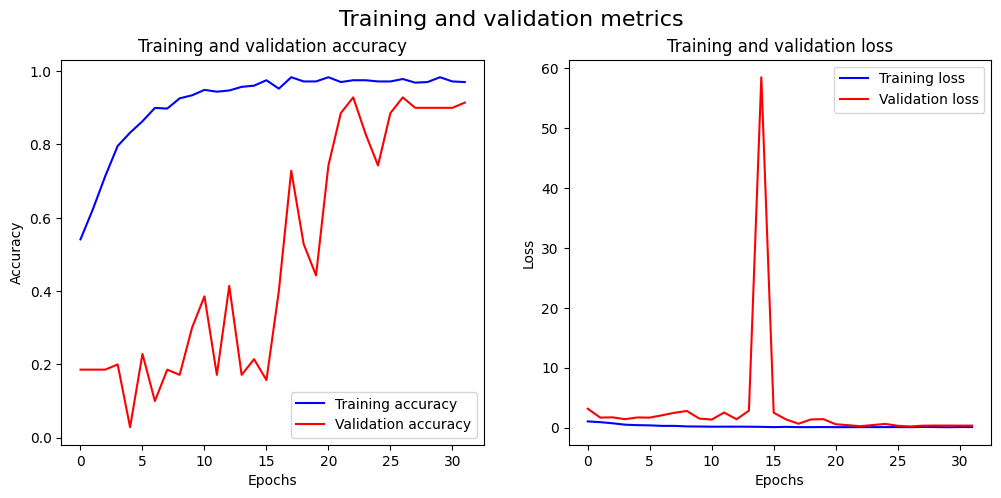

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

accuracy = EffNetB0.history['accuracy']
val_accuracy = EffNetB0.history['val_accuracy']

loss = EffNetB0.history['loss']
val_loss = EffNetB0.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

# 🔮Making predictions¶

1/1 [==============================] - 3s 3s/step
Predicted Label: Squamous cell carcinoma
Actual Label: Squamous cell carcinoma


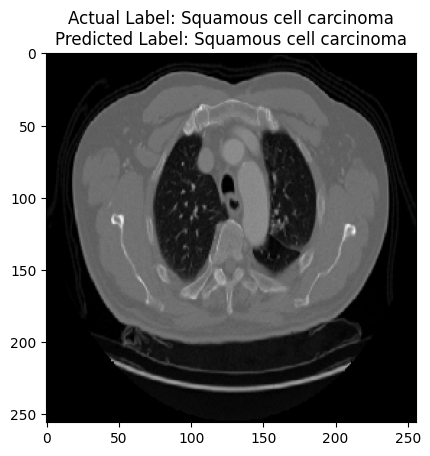

1/1 [==============================] - 0s 154ms/step
Predicted Label: Normal
Actual Label: Normal


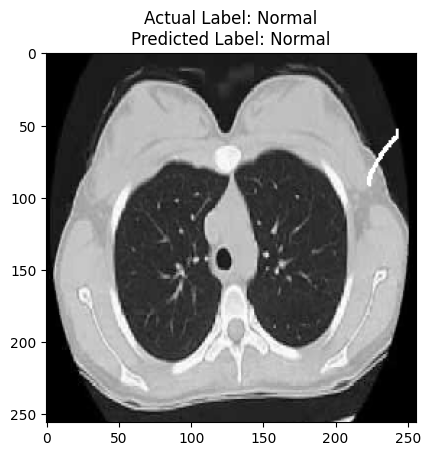

1/1 [==============================] - 0s 161ms/step
Predicted Label: Large cell carcinoma
Actual Label: Large cell carcinoma


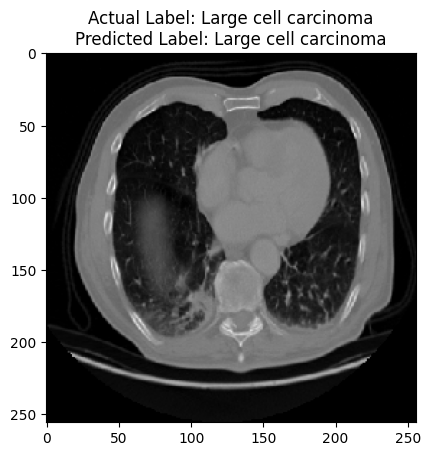

1/1 [==============================] - 0s 157ms/step
Predicted Label: Adenocarcinoma
Actual Label: Adenocarcinoma


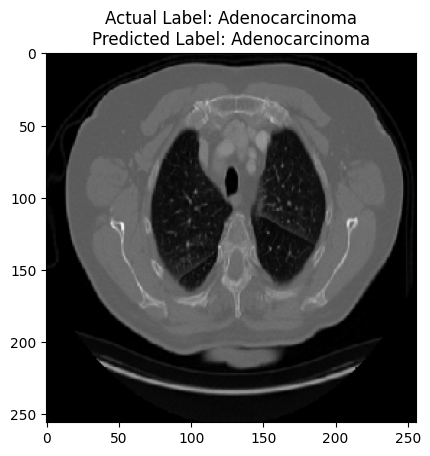

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def chestScanPrediction(paths, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(256, 256))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255

        # Converting Image to Numpy Array
        input_arr_img = np.array([norm_img])

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])

        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

paths = [
    "/content/drive/MyDrive/PIDS/squamous cell carcinoma.png",
    "/content/drive/MyDrive/PIDS/normal.png",
    "/content/drive/MyDrive/PIDS/large cell carcinoma.png",
    "/content/drive/MyDrive/PIDS/adenocarcinoma.png"
]

actual_labels = [3, 2, 1, 0]

chestScanPrediction(paths, EffNetmodel, actual_labels)
